# ASHREA Kaggle competition - time series analysis

The competition ends today so I won't have time to submit results for judging, but I enjoyed the method I implemented and wanted to write out an explenation (I'll probably use the same code later on). With the data from [Kaggle](https://www.kaggle.com/c/ashrae-energy-prediction/data), there are three componets that will need to be combined.

Building Data - there are 15 total sites (cities I'm guessing) with a varying number of buildings in each. The variables are primary_use, square_feet, year_built, and floor_count. With a quick visual inspection of the data, a great deal of both the year_built (~50%) and floor_count (~70%) is missing. However, I believe these variables are too important to simply discard seeing as the year built will represent different building standards, advances in materials, etc. and buildings with the same area will vary greatly (think of a giant 2 story storage facility versus a skyscraper). The visual inspection also showed me that each site_id was pretty consistent with the data. So, for site 1 for example, almost every entry had both variables. I think this means the approach will have to be using 4 models depending on the data present for each site, which breaks down to:

year_built and floor_count = 1,4,5,7
year_built = 0,2,3,15
floor_count = 8,10
neither = 6,9,11,12,13,14

Enviornmental data - the weather for each site, each data is reported in this table. Upon inspre==ection, the cloud coverage is the only variable missing enough data to exclude. I do not think it is important enough to save, seeing that the same information is likely contained in the temperature data. Missing data in the other columns can be filled using an average. Similar to the Building Data, these averages will need to be broken down into those same four groupings above in order to remain consistent.

Meter Reading - This table provides the target of the prediction, the meter reading for a given hour, building, and site over the year 2016. Visual inspection of the data shows a great deal of '0' reading, which I am making the assumption to mean missing. My strategy here will be, for each building and utility combination:

1. For weekends and holidays for 2016, just use an average. Similarly, 2016 was a leap day year, so remove the Feb 29th data as it will not translate to the next two years (provided as the test data by kaggle)
2. drop the missing (= 0) data
3. fit polynomial curves to the remaining data to account for hourly, daily, weekly, and monthly trends
4. create an empty data set of the values missing time series data
5. use the polynomial fits to calculate the missing data along the trendline and combine it back with the original data

Once all of these data preperation steps have been completed, join the building and weather information to each reading, resulting in the df that will be used to create a model with the meter readng as the target.


### Small test set for coding
To start out, I just created a little snippet to create a test data set to speed up coding:

In [18]:
# useful snippet for creating a more maneagable test set
def create_short_raw():
    raw_data = pd.read_csv(r'../New folder/data/train.csv')
    
    raw_data = raw_data[raw_data['building_id'].isin(random.sample(range(0, 1448), 5))]
    raw_data.to_csv(r'data/train_short.csv')

In [8]:
import pandas as pd
import numpy as np
import random 
from matplotlib import pyplot as plt
pd.set_option('mode.chained_assignment', None)

### Building metadata

In [9]:
sid_all = [1,4,5,7 ]
sid_yb = [0,2,3,15]
sid_floors = [8,10]
sid_none = [6,9,11,12,13,14]

raw_data = pd.read_csv('data/building_metadata.csv')
print(raw_data.info(verbose=True),'\n')

raw_data_sid_all = raw_data[raw_data.loc[:,'site_id'].isin(sid_all)]
raw_data_sid_all['year_built'].fillna(raw_data_sid_all['year_built'].mean(), inplace = True) 
raw_data_sid_all['floor_count'].fillna(raw_data_sid_all['floor_count'].mean(), inplace = True)

raw_data_sid_yb = raw_data[raw_data.loc[:,'site_id'].isin(sid_yb)]
raw_data_sid_yb['year_built'].fillna(raw_data_sid_yb['year_built'].mean(), inplace = True)
raw_data_sid_yb['floor_count'] = 0    

raw_data_sid_floors = raw_data[raw_data.loc[:,'site_id'].isin(sid_floors)]
raw_data_sid_floors['year_built'] = 0
raw_data_sid_floors['floor_count'].fillna(raw_data_sid_floors['floor_count'].mean(), inplace = True)

raw_data_sid_none = raw_data[raw_data.loc[:,'site_id'].isin(sid_none)]
raw_data_sid_none['year_built'] = 0
raw_data_sid_none['floor_count'] = 0

building_fixed = pd.concat([raw_data_sid_all, raw_data_sid_yb, raw_data_sid_floors, raw_data_sid_none])

print(building_fixed.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB
None 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1449 entries, 105 to 1324
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     1449 non-null float64
floor_count    1449 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 79.2+ KB
None


### Weather Data

In [11]:

sid_all = [1,4,5,7 ]
sid_yb = [0,2,3,15]
sid_floors = [8,10]
sid_none = [6,9,11,12,13,14]

raw_data = pd.read_csv('data/weather_train.csv')
print(raw_data.info(verbose=True),'\n')
raw_data = raw_data.drop(columns=['cloud_coverage'])

def missing_weather_fill(df):
    df['air_temperature'].fillna(df['air_temperature'].mean(), inplace = True)
    df['dew_temperature'].fillna(df['dew_temperature'].mean(), inplace = True)
    df['precip_depth_1_hr'].fillna(df['precip_depth_1_hr'].mean(), inplace = True)
    df['sea_level_pressure'].fillna(df['sea_level_pressure'].mean(), inplace = True)
    df['wind_direction'].fillna(df['wind_direction'].mean(), inplace = True)
    df['wind_speed'].fillna(df['wind_speed'].mean(), inplace = True)

    return df

raw_data_sid_all = raw_data[raw_data['site_id'].isin(sid_all)]
raw_data_sid_all = missing_weather_fill(raw_data_sid_all)

raw_data_sid_yb = raw_data[raw_data['site_id'].isin(sid_yb)]
raw_data_sid_yb = missing_weather_fill(raw_data_sid_yb)
 
raw_data_sid_floors = raw_data[raw_data['site_id'].isin(sid_floors)]
raw_data_sid_floors = missing_weather_fill(raw_data_sid_floors)

raw_data_sid_none = raw_data[raw_data['site_id'].isin(sid_none)]
raw_data_sid_none = missing_weather_fill(raw_data_sid_none)

weather_fixed = pd.concat([raw_data_sid_all, raw_data_sid_yb, raw_data_sid_floors, raw_data_sid_none])

print(weather_fixed.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null object
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB
None 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139773 entries, 8784 to 131318
Data columns (total 8 columns):
site_id               139773 non-null int64
timestamp             139773 non-null object
air_temperature       139773 non-null float64
dew_temperature       139773 non-null float64
precip_depth_1_hr     139773 non-null float64
sea_level_pressure    139773 non-null float64
wind_direction        1397

### Building Data

The first thing I needed to do was create a dictionary of all of the coefficients that would be created for each building, utility, time unit (hours, days, weeks, and months). Seeing as this will all be called for each building, utility combination I just put it into a class.

In [14]:
class GenerateCoef:
    
    def __init__(self, raw_data, building_id, meter, graph_toggle):
        self.raw_data = raw_data
        self.building_id = building_id
        self.meter = meter
        self.graph_toggle = graph_toggle
        self.data_prep()
        self.separate_off_days()
        self.monthly_coef()
        self.weekly_coef()
        self.daily_coef()
        self.hourly_coef()
        self.ave_meter()

    def data_prep(self):
        day_conv = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, \
                    'Saturday':6, 'Sunday':7}        
        
        self.raw_data.timestamp = pd.to_datetime(self.raw_data.timestamp)
        self.raw_data = self.raw_data.set_index('timestamp')
        
        self.raw_data['H'] = self.raw_data.index.hour
        self.raw_data['D'] = self.raw_data.index.weekday_name
        self.raw_data['W'] = self.raw_data.index.week
        self.raw_data['M'] = self.raw_data.index.month
        self.raw_data['date'] = self.raw_data.index.date
        self.raw_data['D'] = self.raw_data['D'].map(day_conv)
                
    def separate_off_days(self):
        holidays = pd.date_range(start='2016-12-21', end='2016-12-31', freq='D')
        self.raw_data.loc[self.raw_data.date.astype('str').isin(holidays),'D'] = 99
        other_holidays = ['2016-02-29','2016-01-01','2016-05-30','2016-11-24','2016-07-04', \
                          '2016-03-25','2016-01-18','2016-09-05']
        self.raw_data.loc[self.raw_data.date.astype('str').isin(other_holidays),'D'] = 99
        off_hours_data = self.raw_data[self.raw_data.D.isin([6,7,99])]
        self.off_hours_ave = off_hours_data.meter_reading.mean()
        self.raw_data = self.raw_data.drop(off_hours_data.index)
    
    def monthly_coef(self):
        monthly = self.raw_data.groupby('M').meter_reading.mean().reset_index()
        trendM = np.poly1d(np.polyfit(monthly.M, monthly.meter_reading, 6))
        self.monthly_coef = trendM.coef
        self.trendMpoly = np.poly1d(trendM) 

        if self.graph_toggle:
            self.create_graph(self.trendMpoly, monthly, 'M', 'meter_reading')

    def weekly_coef(self):
        self.raw_data['mr_m_adj'] = self.raw_data.meter_reading - self.trendMpoly(self.raw_data.M)
        weekly = self.raw_data.groupby('W').mr_m_adj.mean().reset_index()
        trendW = np.poly1d(np.polyfit(weekly.W, weekly.mr_m_adj, 2))
        self.weekly_coef = trendW.coef
        self.trendWpoly = np.poly1d(trendW) 

        if self.graph_toggle:
            self.create_graph(self.trendWpoly, weekly, 'W', 'mr_m_adj')

    def daily_coef(self):        
        self.raw_data['mr_mw_adj'] = self.raw_data.mr_m_adj - self.trendWpoly(self.raw_data.W)
        daily = self.raw_data.groupby('D').mr_mw_adj.mean().reset_index()
        trendD = np.poly1d(np.polyfit(daily.index+1, daily.mr_mw_adj, 2))
        self.daily_coef = trendD.coef
        self.trendDpoly = np.poly1d(trendD)

        if self.graph_toggle:
            self.create_graph(self.trendDpoly, daily, 'D', 'mr_mw_adj')

    def hourly_coef(self):        
        self.raw_data['mr_mwd_adj'] = self.raw_data.mr_mw_adj - self.trendDpoly(self.raw_data.D)
        hourly = self.raw_data.groupby('H').mr_mwd_adj.mean().reset_index()
        trendH = np.poly1d(np.polyfit(hourly.H, hourly.mr_mwd_adj, 6))
        self.hourly_coef = trendH.coef
        self.trendHpoly = np.poly1d(trendH)
        self.raw_data['mr_mwdh_adj'] = self.raw_data.mr_mwd_adj - self.trendHpoly(self.raw_data.H)

        if self.graph_toggle:
            self.create_graph(self.trendHpoly, hourly, 'H', 'mr_mwd_adj')

    def ave_meter(self):
        self.ave_meter = self.raw_data['mr_mwdh_adj'].mean()
        
    def create_graph(self,trend_poly,df,col,adj_value):
        plt.plot(df[col], df[adj_value],'.')
        plt.plot(df[col],trend_poly(df[col]))
        plt.show()

In order to call this class and populate the dictionary I wanted to back-calculate missing values, I built the following function:

In [21]:
def generate_coef_dict(raw_data):
    coef_dict ={}
    data_comb = raw_data[['building_id','meter']].copy().drop_duplicates()    
    
    for building in raw_data.building_id.unique():
        rd_temp_bldg = raw_data[raw_data['building_id'] == building].copy()
        for util in rd_temp_bldg.meter.unique():
            rd_temp_bldg_util = rd_temp_bldg[rd_temp_bldg['meter'] == util].copy()
            print(building, util, len(rd_temp_bldg_util))
            
            generate_coef = GenerateCoef(rd_temp_bldg_util, building, util, True)
            
            coef_dict[str(building), str(util), 'M'] = generate_coef.monthly_coef
            coef_dict[str(building), str(util), 'W'] = generate_coef.weekly_coef
            coef_dict[str(building), str(util), 'D'] = generate_coef.daily_coef
            coef_dict[str(building), str(util), 'H'] = generate_coef.hourly_coef
            
            data_comb.loc[((data_comb['building_id'] == building) & 
                           (data_comb['meter'] == util)),'meter_ave'] = generate_coef.ave_meter            
            data_comb.loc[((data_comb['building_id'] == building) & \
                           (data_comb['meter'] == util)),'off_hours_ave'] = generate_coef.off_hours_ave
    
    np.save('coef_dict.npy', coef_dict)
    data_comb.to_pickle('data_comb.pkl')
    return coef_dict, data_comb      

In order to break each timestamp into its components, I created the following function (to do: combine this with the data prep in the class above):

In [16]:
def date_breakdown(df):
    day_conv = {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, \
                'Saturday':6, 'Sunday':7}   
    df['H'] = df.index.hour
    df['M'] = df.index.month
    df['W'] = df.index.week
    df['D'] = df.index.weekday_name
    df['date'] = df.index.date
    df['D'] = df['D'].map(day_conv)
    df = df.fillna(0)        
    
    return df

The following function fills in the missing data using the coefficient dictionary created earlier and stores the output:

In [17]:
def fill_timeseries(raw_data, coef_dict, data_comb):
    # create a blank date range df and filter out the existing data
    index = pd.date_range(start='1/1/2016', end='12/31/2016', freq = 'H')
    columns = ['timestamp']
    missing = pd.DataFrame(index=index, columns=columns)
    missing.index = pd.to_datetime(missing.index)
    missing['meter_reading'] = 0
    missing = date_breakdown(missing)
    
    corrected_data = pd.DataFrame()
    
    raw_data['timestamp'] = pd.to_datetime(raw_data['timestamp'])
    raw_data = raw_data.set_index('timestamp')
    raw_data = date_breakdown(raw_data)
    
    for building in raw_data.building_id.unique():
        temp_raw = raw_data[raw_data['building_id'] == building].copy()
        temp_building = pd.DataFrame()
        for util in temp_raw.meter.unique():
            temp_util_raw = raw_data[raw_data['meter'] == util].copy()
            temp_missing = missing.copy()
            if len(temp_missing) > len(temp_util_raw):
                temp_missing = temp_missing.drop(temp_util_raw.index, errors = 'ignore')
    
                # drop the existing data index to find the missing data
                temp_missing = temp_missing.drop(temp_util_raw.index, errors = 'ignore')
    
                temp_missing['building_id'] = building
                temp_missing['meter'] = util            
                
                # pull out the holidays and weekend, use a simple average for those
                holidays = pd.date_range(start='2016-12-21', end='2016-12-31', freq='D')
                temp_missing.loc[temp_missing.date.astype('str').isin(holidays),'D'] = 99
                #2016 was a leap year day
                other_holidays = ['2016-02-29','2016-01-01','2016-05-30','2016-11-24',\
                                  '2016-07-04','2016-03-25','2016-01-18','2016-09-05']
                temp_missing.loc[temp_missing.date.astype('str').isin(other_holidays),'D'] = 99

                off_hours_temp = temp_missing[temp_missing.D.isin([6,7,99])].copy()
                temp_ave_meter = data_comb.loc[((data_comb['building_id'] == building) & \
                                                (data_comb['meter'] == util)),'off_hours_ave']
                # *** first df to add
                off_hours_temp.loc[:,'meter_reading'] = temp_ave_meter
                temp_missing = temp_missing.drop(off_hours_temp.index)
                
                # cycle through each hour
                for index, row in temp_missing.iterrows():
                    meter_temp = 0
                    # use the coeficcients in reverse order to calculate the missing meter readings
                    for time_unit in ['M','W','D','H']:
                        p = np.poly1d(coef_dict[(str(building),str(util),str(time_unit))])            
                        meter_temp = meter_temp + p(temp_missing.loc[index, time_unit])
                        # (-) meter readings dont occur, so eliminate the possibility
                        if meter_temp < 0:
                            meter_temp = 0
                    temp_missing.loc[index,'meter_reading'] = meter_temp
                    #print(time_unit, index, p(temp_missing.loc[index, time_unit]), temp_save, meter_temp)    
                temp_missing = pd.concat([temp_missing, off_hours_temp])
            temp_building = pd.concat([temp_building,temp_missing])
            
        corrected_data = pd.concat([corrected_data,temp_building])
    
    corrected_data.to_csv('test.csv',mode='a', header=False)
    corrected_data[corrected_data['meter_reading'].isnull()] = 0

Last, we just need to call everything. Monay of these steps only need to completed once, so just a little logic that would normally go into a config given more time. This step takes some time to cycle through each building, utility combination:

335 0 8781


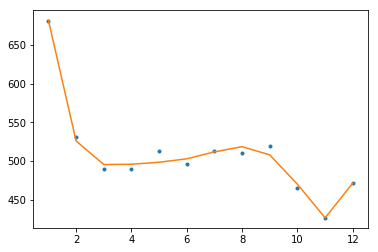

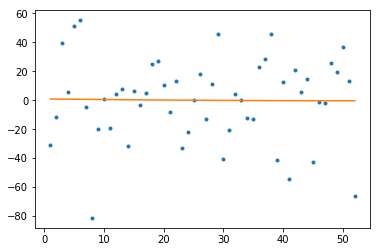

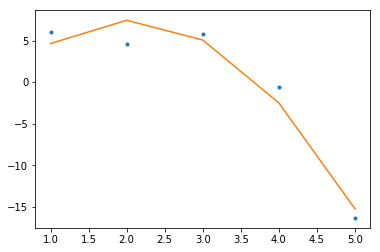

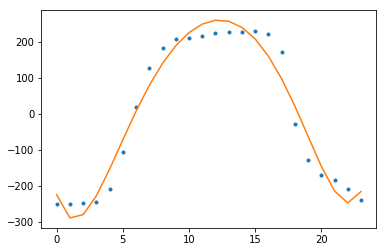

521 0 8711


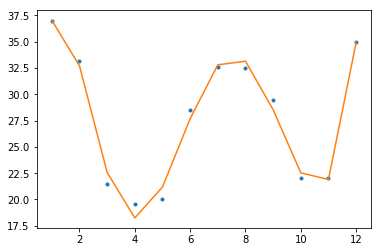

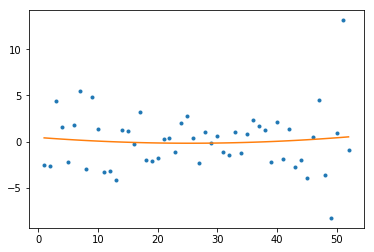

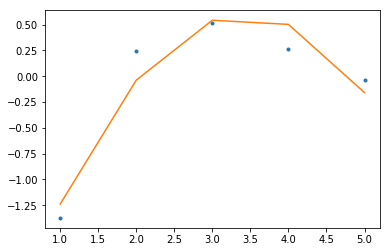

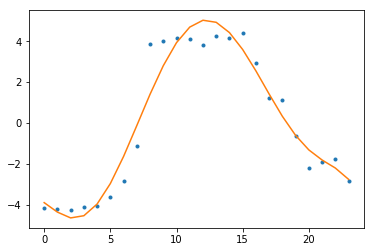

596 0 8775


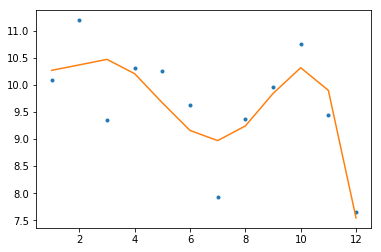

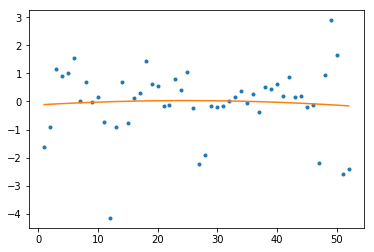

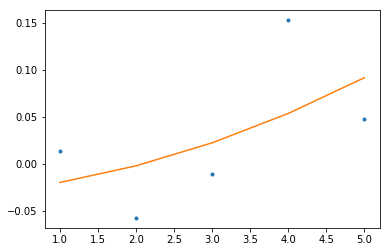

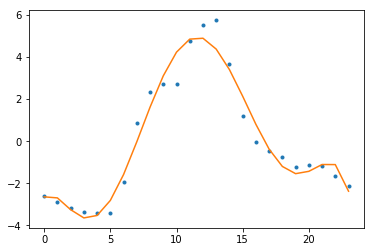

1435 0 7472


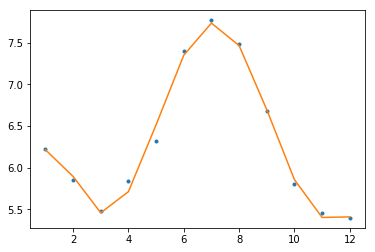

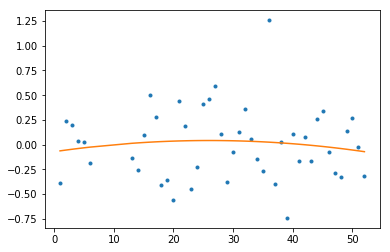

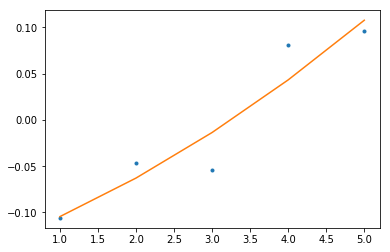

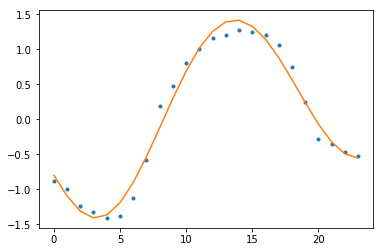

961 0 8560


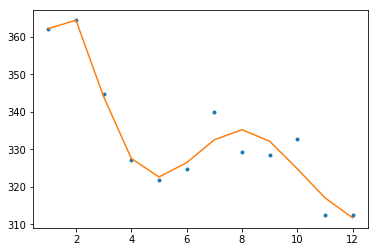

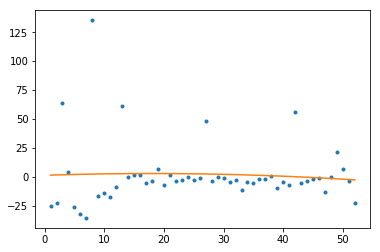

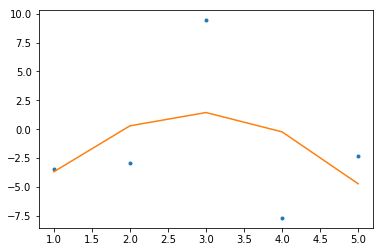

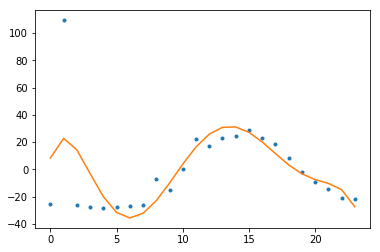

961 1 8293


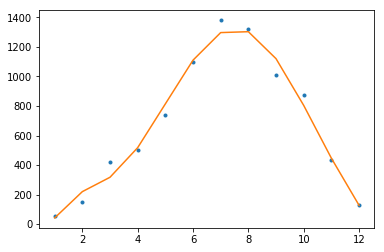

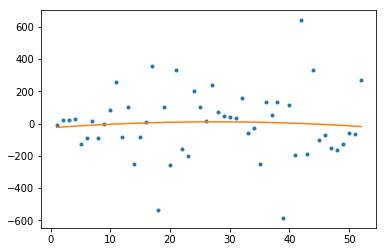

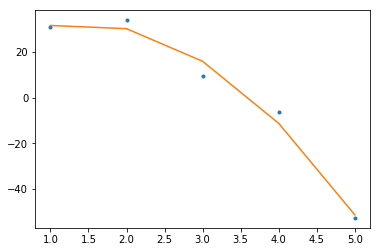

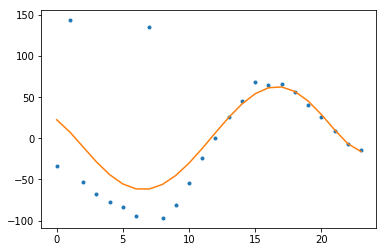

961 2 8121


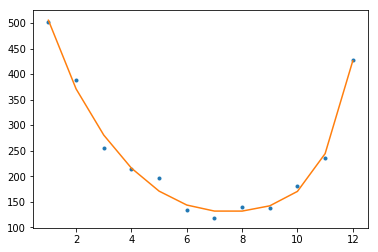

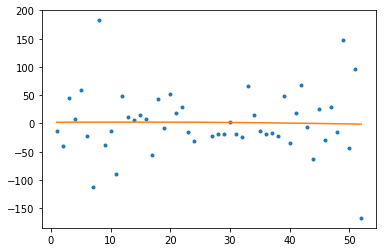

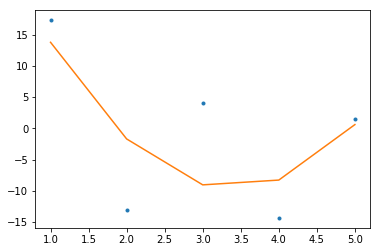

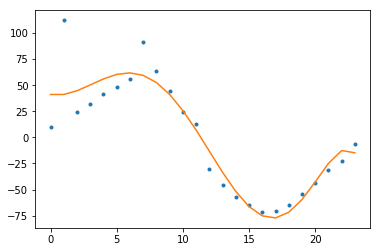

In [22]:
create_short = True
use_short = True
generate_coef = True
fill_ts = False

if use_short:
    raw_data = pd.read_csv('data/train_short.csv')
    # assumption: '0' readings are mistakes and should be omitted
    raw_data = raw_data[raw_data['meter_reading'] != 0]    
else:
    raw_data = pd.read_csv('/data/train.csv')
    # assumption: '0' readings are mistakes and should be omitted
    raw_data = raw_data[raw_data['meter_reading'] != 0]        

if create_short:
    create_short_raw()
if generate_coef:
    coef_dict, data_comb  = generate_coef_dict(raw_data)     
if fill_ts:
    data_comb = pd.read_pickle('data_comb.pkl')
    coef_dict = np.load('coef_dict.npy',allow_pickle='TRUE').item()
    fill_timeseries(raw_data, coef_dict, data_comb)